# 數值預測的任務

我們先載入這個章節範例程式碼中會使用到的第三方套件、模組或者其中的部分類別、函式。

In [1]:
from pyvizml import CreateNBAData
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## 關於數值預測的任務

「數值預測」是「監督式學習」的其中一種應用類型，當預測的目標向量 $y$ 屬於連續型的數值變數，那我們就能預期正在面對數值預測的任務，更廣泛被眾人知悉的名稱為「迴歸模型」。例如預測的目標向量 $y$ 是 `players` 資料中的 `weightKilograms`，在資料類別中屬於連續型的數值類別 `float`；具體來說，迴歸模型想方設法將特徵矩陣 $X$ 與目標向量 $y$ 之間的關聯以一條迴歸線（Regression Line）描繪，而描繪迴歸線所依據的截距項和係數項，就是用來逼近 $f$ 的 $h$。

我們也可依 [Tom Mitchel](https://en.wikipedia.org/wiki/Tom_M._Mitchell) 對機器學習電腦程式的定義寫下數值預測的資料、任務、評估與但書，以預測 `players` 資料中的 `weightKilograms` 為例：

- 資料（Experience）：一定數量的球員資料
- 任務（Task）：利用模型預測球員的體重
- 評估（Performance）：模型預測的體重與球員實際體重的誤差大小
- 但書（Condition）：隨著資料觀測值筆數增加，預測誤差應該要減少

In [2]:
# players 資料中的 weightKilograms
cnd = CreateNBAData(2019)
players = cnd.create_players_df()
y = players['weightKilograms'].values.astype(float)
y.dtype

Creating players df...


dtype('float64')

## 以 Scikit-Learn 預測器完成數值預測任務

將 `heightMeters` 當作特徵矩陣為例，特徵矩陣 $X$ 與目標向量 $y$ 之間的關聯可以這樣描述。

\begin{equation}
\hat{y} = w_0 + w_1x_1
\end{equation}

以 Scikit-Learn 定義好的預測器類別 `LinearRegression` 可以快速找出描繪迴歸線所依據的截距項 $w_0$ 和係數項 $w_1$。

In [3]:
X = players['heightMeters'].values.astype(float).reshape(-1, 1)
y = players['weightKilograms'].values.astype(float)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
h = LinearRegression()
h.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [4]:
print(h.intercept_) # 截距項
print(h.coef_)      # 係數項

-104.22092448587175
[101.82540151]


In [5]:
# 預測
y_pred = h.predict(X_valid)
y_pred[:10]

array([107.57591065,  82.11956027, 100.44813254, 105.53940262,
        95.35686246, 112.66718072,  92.30210042,  92.30210042,
        97.39337049,  95.35686246])

找出 $w_0$ 與 $w_1$ 就能夠描繪出一條迴歸線表達特徵矩陣 $X$ 與目標向量 $y$。

In [6]:
# 創建迴歸線的資料
X1 = np.linspace(X.min()-0.1, X.max()+0.1).reshape(-1, 1)
y_hat = h.predict(X1)

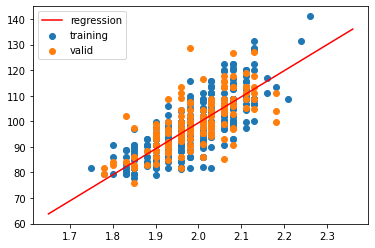

In [7]:
# 描繪迴歸線
fig, ax = plt.subplots()
ax.scatter(X_train.ravel(), y_train, label="training")
ax.scatter(X_valid.ravel(), y_valid, label="valid")
ax.plot(X1.ravel(), y_hat, c="red", label="regression")
ax.legend()
plt.show()

使用 Scikit-Learn 預測器的最關鍵方法呼叫是 `fit()` 方法，究竟它是如何決定 `X_train` 與 `y_train` 之間的關聯 $w$？接下來我們試圖推導並理解它。

## 正規方程 Normal Equation

使用機器學習解決數值預測的任務，顧名思義是能夠創建出一個 $h$ 函式，這個函式可以將無標籤資料 $x$ 作為輸入，並預測目標向量 $y$ 的值作為其輸出。

\begin{align}
\hat{y} &= h(x; w) \\
&= w_0 + w_1x_1 + ... + w_nx_n
\end{align}

為了寫作成向量相乘形式，為 $w_0$ 補上 $x_0=1$：

\begin{align}
\hat{y} &= w_0x_0 + w_1x_1 + ... + w_nx_n, \; where \; w_0 = 1 \\
&= w^Tx
\end{align}

其中 $\hat{y}$ 是預測值、$n$ 是特徵個數、$w$ 是係數向量；並能夠進一步延展為 `m` 筆觀測值的外觀為：

\begin{equation}
\hat{y} = h(X; w) = 
\begin{bmatrix} x_{00}, x_{01}, ..., x_{0n} \\ x_{10}, x_{11}, ..., x_{1n} \\.\\.\\.\\ x_{m0}, x_{m1}, ..., x_{mn}
\end{bmatrix}
\begin{bmatrix} w_0 \\ w_1 \\.\\.\\.\\ w_n \end{bmatrix} = Xw
\end{equation}

$h(X; w)$ 是基於 $w$ 的函式，如果第 $i$ 個特徵 $x_i$ 對應的係數 $w_i$ 為正數，該特徵與 $\hat{y}$ 的變動同向；如果第 $i$ 個特徵 $x_i$ 對應的係數 $w_i$ 為負數，該特徵與 $\hat{y}$ 的變動反向；如果第 $i$ 個特徵 $x_i$ 對應的係數 $w_i$ 為零，該特徵對 $\hat{y}$ 的變動沒有影響。

截至於此，資料（Experiment）與任務（Task）已經被定義妥善，特徵矩陣 $X$ 外觀 `(m, n)`、目標向量 $y$ 外觀 `(m,)`、係數向量 $w$ 外觀 `(n,)`，通過將 $X$ 輸入 $h$ 來預測 $\hat{y}$，接下來還需要定義評估（Performance）。

評估 $h$ 的方法是計算 $y^{(train)}$ 與 $\hat{y}^{(train)}$ 之間的均方誤差（Mean squared error）：

\begin{equation}
MSE_{train} = \frac{1}{m}\sum_i(y^{(train)} - \hat{y}^{(train)})_i^2
\end{equation}

如果寫為向量運算的外觀：

\begin{equation}
MSE_{train} = \frac{1}{m}\parallel y^{(train)} - \hat{y}^{(train)} \parallel^2
\end{equation}

電腦程式能夠通過觀察訓練資料藉此獲得一組能讓均方誤差最小化的係數向量 $w$，為了達成這個目的，將均方誤差表達為一個基於係數向量 $w$ 的函式 $J(w)$：

\begin{equation}
J(w) = MSE = \frac{1}{m} \parallel y - Xw \parallel^2
\end{equation}

整理一下函式 $J(w)$ 的外觀：

\begin{align}
J(w) &= \frac{1}{m}(Xw - y)^T(Xw - y) \\
&= \frac{1}{m}(w^TX^T - y^T)(Xw - y) \\
&= \frac{1}{m}(w^TX^TXw - w^TX^Ty - y^TXw + y^Ty) \\
&= \frac{1}{m}(w^TX^TXw - (Xw)^Ty - y^TXw + y^Ty) \\
&= \frac{1}{m}(w^TX^TXw - 2(Xw)^Ty + y^Ty)
\end{align}

求解 $J(w)$ 斜率為零的位置：

\begin{gather}
\frac{\partial}{\partial w} J(w) = 0 \\
2X^TXw - 2X^Ty = 0 \\
X^TXw = X^Ty \\
w^* = (X^TX)^{-1}X^Ty
\end{gather}

這個 $w^*$ 求解亦被稱呼為「正規方程」（Normal equation）。

## 自訂正規方程類別 NormalEquation

我們可以依據正規方程自訂預測器類別，並與 Scikit-Learn 定義好的預測器類別 `LinearRegression` 比對係數向量是否一致。

In [8]:
class NormalEquation:
    """
    This class defines the Normal equation for linear regression.
    Args:
        fit_intercept (bool): Whether to add intercept for this model.
    """
    def __init__(self, fit_intercept=True):
        self._fit_intercept = fit_intercept
    def fit(self, X_train, y_train):
        """
        This function uses Normal equation to solve for weights of this model.
        Args:
            X_train (ndarray): 2d-array for feature matrix of training data.
            y_train (ndarray): 1d-array for target vector of training data.
        """
        self._X_train = X_train.copy()
        self._y_train = y_train.copy()
        m = self._X_train.shape[0]
        if self._fit_intercept:
            X0 = np.ones((m, 1), dtype=float)
            self._X_train = np.concatenate([X0, self._X_train], axis=1)
        X_train_T = np.transpose(self._X_train)
        left_matrix = np.dot(X_train_T, self._X_train)
        right_matrix = np.dot(X_train_T, self._y_train)
        left_matrix_inv = np.linalg.inv(left_matrix)
        w = np.dot(left_matrix_inv, right_matrix)
        w_ravel = w.ravel().copy()
        self._w = w
        self.intercept_ = w_ravel[0]
        self.coef_ = w_ravel[1:]
    def predict(self, X_test):
        """
        This function returns predicted values with weights of this model.
        Args:
            X_test (ndarray): 2d-array for feature matrix of test data.
        """
        self._X_test = X_test.copy()
        m = self._X_test.shape[0]
        if self._fit_intercept:
            X0 = np.ones((m, 1), dtype=float)
            self._X_test = np.concatenate([X0, self._X_test], axis=1)
        y_pred = np.dot(self._X_test, self._w)
        return y_pred

In [9]:
h = NormalEquation()
h.fit(X_train, y_train)

In [10]:
print(h.intercept_) # 截距項
print(h.coef_)      # 係數項

-104.22092448572948
[101.82540151]


In [11]:
# 預測
y_pred = h.predict(X_valid)
y_pred[:10]

array([107.57591065,  82.11956027, 100.44813254, 105.53940262,
        95.35686246, 112.66718072,  92.30210042,  92.30210042,
        97.39337049,  95.35686246])

比對 $w$ 與前十筆預測值可以驗證自行定義的 `NormalEquation` 類別與 Scikit-Learn 求解 $w$ 的邏輯相近。

## 計算複雜性

計算複雜性（Computational complexity）是電腦科學研究解決問題所需的資源，諸如時間（要通過多少步演算才能解決問題）和空間（在解決問題時需要多少記憶體），在演算法中常見到的大 O 符號就是表示演算所需時間的表達式。在正規方程中必須要透過計算 $X^TX$ 的反矩陣 $(X^TX)^{-1}$ 求解 $w^*$，這是一個外觀 `(n+1, n+1)` 的二維數值陣列（`n` 為特徵個數），計算複雜性最多是 $O(n^3)$，這意味著如果特徵個數變為 2 倍，計算 $(X^TX)^{-1}$ 的時間最多會變為 8 倍。因此當面對的特徵矩陣 `n` 很大（約莫是大於 $10^4$），正規方程的計算複雜性問題就會浮現，這時讀者可能會好奇 $n \geq 10^4$ 會很容易遭遇嗎？在特徵矩陣是圖像時很容易遭遇，例如低解析度 $100 \: px \times 100 \: px$ 的灰階圖片。

## 梯度遞減 Gradient Descent

另外一種在機器學習、深度學習中更為廣泛使用的演算方法稱為「梯度遞減」（Gradient descent），基本概念是先隨機初始化一組係數向量，在基於降低 $y^{(train)}$ 與 $\hat{y}^{(train)}$ 之間誤差 $J(w)$ 之目的標之下，以迭代方式更新該組係數向量，一直到 $J(w)$ 收斂到局部最小值為止。

梯度遞減的精髓在於當演算方法更新係數向量時，並不是盲目亂槍打鳥地試誤（Trial and error），而是透過「有方向性」的依據進行更新，具體來說，就是根據誤差函式 $J(w)$ 關於係數向量 $w$ 的偏微分來決定更新的方向性，而更新的幅度大小則由一個大於零、稱為「學習速率」的常數 $\alpha$ 決定：

\begin{equation}
w := w - \alpha \frac{\partial J}{\partial w}
\end{equation}

讓我們用一個簡單的例子來看為什麼透過這個式子更新 $w$ 是一種「有方向性」的依據，舉例來說如果給定一組 $X^{(train)}$ 與 $y^{(train)}$：

In [12]:
X0 = np.ones((10, 1))
X1 = np.arange(1, 11).reshape(-1, 1)
w = np.array([5, 6])
X_train = np.concatenate([X0, X1], axis=1)
y_train = np.dot(X_train, w)
print(X_train)
print(y_train)

[[ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 1.  5.]
 [ 1.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]]
[11. 17. 23. 29. 35. 41. 47. 53. 59. 65.]


從後見之明的視角來看，我們會知道係數向量 $w^*$ 的組成 $w_0=5$、$w_1=6$：

\begin{equation}
f(x) = y = 5x_0 + 6x_1
\end{equation}

亦即

\begin{equation}
w^* = \begin{bmatrix} w_0^* \\ w_1^* \end{bmatrix} = \begin{bmatrix} 5 \\ 6 \end{bmatrix}
\end{equation}

不過給定電腦程式一組 $X^{(train)}$ 與 $y^{(train)}$ 對於它來說像是拋出了一個大海撈針的問題，有無限多組的 $w$ 等著要嘗試（它甚至不知道用 $w_0$ 與 $w_1$ 就可以找到跟 $f$ 完全相同的 $h$），遑論找出 $w_0=5$、$w_1=6$；「梯度遞減」演算方法就是為電腦程式提供了一個尋找解題的方式，千里之行，始於足下，請先隨機初始化一組 $w$：

In [13]:
np.random.seed(42)
w = np.random.rand(2)
w

array([0.37454012, 0.95071431])

針對這組 $w$ 可以得到一組 $\hat{y}^{(train)}$：

In [14]:
y_hat = np.dot(X_train, w)
y_hat

array([1.32525443, 2.27596873, 3.22668304, 4.17739734, 5.12811165,
       6.07882596, 7.02954026, 7.98025457, 8.93096888, 9.88168318])

針對這組 $\hat{y}^{(train)}$ 可以計算與 $y^{(train)}$ 的均方誤差。

\begin{equation}
J(w) = \frac{1}{m}\parallel y - Xw \parallel^2
\end{equation}

In [15]:
m = y_train.size
j = ((y_hat - y_train).T.dot(y_hat - y_train)) / m
j

1259.87134315462

那麼下一次的試誤該如何更新 $w$ 才能確保離 $w^*$ 更近，讓計算出來的均方誤差會更小一些？這時梯度遞減演算方法登場，它直截了當地說：請將目前的 $w_0$ 減去學習速率 $\alpha$ 乘上 $J(w)$ 關於 $w_0$ 的偏微分、將目前的 $w_1$ 減去學習速率 $\alpha$ 乘上 $J(w)$ 關於 $w_1$ 的偏微分：

\begin{equation}
w_0 := w_0 - \alpha \frac{\partial J}{\partial w_0}
\end{equation}

\begin{equation}
w_1 := w_1 - \alpha \frac{\partial J}{\partial w_1}
\end{equation}

以係數向量的外觀表示：

\begin{equation}
w := w - \alpha \frac{\partial J}{\partial w}
\end{equation}

接著慢慢將 $J(w)$ 關於 $w$ 的偏微分式子展開：

\begin{align}
\frac{\partial J}{\partial w} &= \frac{1}{m}\frac{\partial}{\partial w}(\parallel y - Xw \parallel^2) \\
&= \frac{1}{m}\frac{\partial}{\partial w}(Xw - y)^T(Xw-y) \\
&= \frac{1}{m}\frac{\partial}{\partial w}(w^TX^TXw - w^TX^Ty - y^TXw + y^Ty) \\
&= \frac{1}{m}\frac{\partial}{\partial w}(w^TX^TXw - (Xw)^Ty - (Xw)^Ty + y^Ty) \\
&= \frac{1}{m}\frac{\partial}{\partial w}(w^TX^TXw - 2(Xw)^Ty + y^Ty) \\
&= \frac{1}{m}(2X^TXw - 2X^Ty) \\
&= \frac{2}{m}(X^TXw - X^Ty) \\
&= \frac{2}{m}X^T(Xw - y) \\
&= \frac{2}{m}X^T(\hat{y} - y)
\end{align}

$J(w)$ 關於 $w$ 的偏微分就是演算方法中所謂的「梯度」（Gradient），在迭代過程中 $w$ 更新的方向性取決於梯度正負號，如果梯度為正，$w$ 會向左更新（減小）；如果梯度為負，$w$ 會向右更新（增大）。

\begin{equation}
w := w - \alpha \frac{2}{m}X^T(\hat{y} - y)
\end{equation}

接著計算隨機初始化的 $w$ 其梯度為何。

In [16]:
gradients = (2/m) * np.dot(X_train.T, y_hat - y_train)
gradients

array([ -64.79306239, -439.6750571 ])

當梯度為負，隨機初始化的 $w$ 會向右更新（增大），離後見之明視角所知的 $w_0 = 5$、$w_1 = 6$ 更加接近，在更新的方向性上是正確的。假設將學習速率設定為 0.001，更新的幅度就是：

In [17]:
learning_rate = 0.001
-learning_rate * gradients

array([0.06479306, 0.43967506])

經過第一次迭代更新後的 $w$：

In [18]:
w -= learning_rate * gradients
w

array([0.43933318, 1.39038936])

針對更新過一次的 $w$ 可以得到一組 $\hat{y}^{(train)}$：

In [19]:
y_hat = np.dot(X_train, w)
y_hat

array([ 1.82972254,  3.22011191,  4.61050127,  6.00089064,  7.39128   ,
        8.78166936, 10.17205873, 11.56244809, 12.95283745, 14.34322682])

更新過一次的 $w$ 所對應的均方誤差：

In [20]:
j = ((y_hat - y_train).T.dot(y_hat - y_train)) / m
j

1070.1192063534622

從上述例子可以觀察到運用「梯度遞減」演算方法迭代更新係數向量的過程中，透過計算誤差函式關於係數向量的梯度決定更新的**方向性**，透過學習速率決定更新的**幅度**，在迭代進行一次之後，係數向右更新（增大）離真實的 $w^*$ 更接近了些、均方誤差也下降了些。

## 自訂梯度遞減類別 GradientDescent

我們可以依據梯度遞減自訂預測器類別，檢視迭代後的 $w$ 是否與後見之明視角的 $w_0 = 5$、$w_1 = 6$ 相近、均方誤差是否隨著迭代而下降。

In [21]:
class GradientDescent:
    """
    This class defines the vanilla gradient descent algorithm for linear regression.
    Args:
        fit_intercept (bool): Whether to add intercept for this model.
    """
    def __init__(self, fit_intercept=True):
        self._fit_intercept = fit_intercept
    def find_gradient(self):
        """
        This function returns the gradient given certain model weights.
        """
        y_hat = np.dot(self._X_train, self._w)
        gradient = (2/self._m) * np.dot(self._X_train.T, y_hat - self._y_train)
        return gradient
    def mean_squared_error(self):
        """
        This function returns the mean squared error given certain model weights.
        """
        y_hat = np.dot(self._X_train, self._w)
        mse = ((y_hat - self._y_train).T.dot(y_hat - self._y_train)) / self._m
        return mse
    def fit(self, X_train, y_train, epochs=10000, learning_rate=0.001):
        """
        This function uses vanilla gradient descent to solve for weights of this model.
        Args:
            X_train (ndarray): 2d-array for feature matrix of training data.
            y_train (ndarray): 1d-array for target vector of training data.
            epochs (int): The number of iterations to update the model weights.
            learning_rate (float): The learning rate of gradient descent.
        """
        self._X_train = X_train.copy()
        self._y_train = y_train.copy()
        self._m = self._X_train.shape[0]
        if self._fit_intercept:
            X0 = np.ones((self._m, 1), dtype=float)
            self._X_train = np.concatenate([X0, self._X_train], axis=1)
        n = self._X_train.shape[1]
        self._w = np.random.rand(n)
        n_prints = 10
        print_iter = epochs // n_prints
        w_history = dict()
        for i in range(epochs):
            current_w = self._w.copy()
            w_history[i] = current_w
            mse = self.mean_squared_error()
            gradient = self.find_gradient()
            if i % print_iter == 0:
                print("epoch: {:6} - loss: {:.6f}".format(i, mse))
            self._w -= learning_rate*gradient
        w_ravel = self._w.copy().ravel()
        self.intercept_ = w_ravel[0]
        self.coef_ = w_ravel[1:]
        self._w_history = w_history
    def predict(self, X_test):
        """
        This function returns predicted values with weights of this model.
        Args:
            X_test (ndarray): 2d-array for feature matrix of test data.
        """
        self._X_test = X_test
        m = self._X_test.shape[0]
        if self._fit_intercept:
            X0 = np.ones((m, 1), dtype=float)
            self._X_test = np.concatenate([X0, self._X_test], axis=1)
        y_pred = np.dot(self._X_test, self._w)
        return y_pred

In [22]:
h = GradientDescent(fit_intercept=False)
h.fit(X_train, y_train, epochs=20000, learning_rate=0.001)

epoch:      0 - loss: 1395.016289
epoch:   2000 - loss: 0.467521
epoch:   4000 - loss: 0.087119
epoch:   6000 - loss: 0.016234
epoch:   8000 - loss: 0.003025
epoch:  10000 - loss: 0.000564
epoch:  12000 - loss: 0.000105
epoch:  14000 - loss: 0.000020
epoch:  16000 - loss: 0.000004
epoch:  18000 - loss: 0.000001


In [23]:
print(h.intercept_) # 截距項
print(h.coef_)      # 係數項

4.9992312515155835
[6.00011042]


最後我們將自訂的梯度遞減預測器類別應用在真實的 `players` 資料，並且與 Scikit-Learn 預測器類別、正規方程類別所求得的 $w$ 比對。

In [24]:
X = players['heightMeters'].values.astype(float).reshape(-1, 1)
y = players['weightKilograms'].values.astype(float)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
h = GradientDescent()
h.fit(X_train, y_train, epochs=300000, learning_rate=0.01)

epoch:      0 - loss: 9727.248118
epoch:  30000 - loss: 53.087449
epoch:  60000 - loss: 49.159273
epoch:  90000 - loss: 48.548584
epoch: 120000 - loss: 48.453643
epoch: 150000 - loss: 48.438884
epoch: 180000 - loss: 48.436589
epoch: 210000 - loss: 48.436232
epoch: 240000 - loss: 48.436177
epoch: 270000 - loss: 48.436168


In [25]:
print(h.intercept_) # 截距項
print(h.coef_)      # 係數項

-104.2096510036928
[101.81974607]


In [26]:
# 預測
y_pred = h.predict(X_valid)
y_pred[:10]

array([107.57542082,  82.1204843 , 100.4480386 , 105.5390259 ,
        95.35705129, 112.66640812,  92.30245891,  92.30245891,
        97.39344621,  95.35705129])

比對 $w$ 與前十筆預測值可以驗證自行定義的 `GradientDescent` 類別與 Scikit-Learn 求解的邏輯相近。

我們用簡潔的一段話總結數值預測任務：面對屬於連續型的數值目標向量 $y$，讓電腦程式透過觀察訓練資料 $X^{(train)}$ 與 $y^{(train)}$，基於最小化 $y^{(train)}$ 與 $\hat{y}^{(train)}$ 間的誤差 $J(w)$，透過正規方程或者梯度遞減的演算方法，尋找出係數向量 $w^*$ 建構出一個 $h(X; w^*)$ 去近似假設存在能完美對應 $X$ 和 $y$ 的 $f$。

## 標準化與進階的梯度遞減

目前自行定義的 `GradientDescent` 類別是屬於單純的最適化手法，為什麼用「單純」來形容？我們再回顧梯度遞減的核心概念：

\begin{equation}
w := w - \alpha \frac{\partial J}{\partial w}
\end{equation}

在這個演算方法可以清楚觀察到 $w$ 的更新依據有兩個：學習速率 $\alpha$ 與梯度 $\frac{\partial J}{\partial w}$，其中學習速率使用一個事先決定的常數，在訓練過程固定不變，梯度也是該次迭代當下的快照；在這樣的設計理念之下，當 $w_i$ 彼此的量值級距差距大，將會發生不效率的最適化。以跑步來比喻，在短距離的場地賽應該要穿著釘鞋與使用九成最大攝氧量的配速競賽、在長距離的路跑賽應該要穿著厚底鞋與使用七成最大攝氧量的配速競賽，然而使用固定的學習速率、只考慮單下的梯度，就像是用同一套裝備與配速去面對距離不同的賽事一般，無法有出色的表現。以 [Kaggle](https://www.kaggle.com/) 網站所下載回來的[艾姆斯房價](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)資料為例，若以其中的 `GrLivArea` 作為特徵矩陣來預測目標向量 `SalePrice`，以 Scikit-Learn 的 `LinearRegression` 預測器類別可以獲知 $w^*$。

In [27]:
train = pd.read_csv("https://kaggle-getting-started.s3-ap-northeast-1.amazonaws.com/house-prices/train.csv")
X = train['GrLivArea'].values.reshape(-1, 1)
y = train['SalePrice'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)

30774.037736162078
[98.50395317]


如果使用自行定義的 `GradientDescent` 類別，會發現不論怎麼調整學習速率、增加訓練的迭代次數，$w$ 都離理想值距離甚遠。

In [28]:
h = GradientDescent()
h.fit(X_train, y_train, epochs=500000, learning_rate=1e-7) # 無法使用更大的學習速率，誤差會高到發生溢位

epoch:      0 - loss: 38051606006.512634
epoch:  50000 - loss: 3240902379.450190
epoch: 100000 - loss: 3240693358.485150
epoch: 150000 - loss: 3240484776.905393
epoch: 200000 - loss: 3240276633.787285
epoch: 250000 - loss: 3240068928.209129
epoch: 300000 - loss: 3239861659.251170
epoch: 350000 - loss: 3239654825.995579
epoch: 400000 - loss: 3239448427.526465
epoch: 450000 - loss: 3239242462.929857


In [29]:
print(h.intercept_)
print(h.coef_)

322.21983727161654
[116.36489226]


In [30]:
def plot_contour(X_train, y_train, w_history, w_0_min, w_0_max, w_1_min, w_1_max, w_0_star, w_1_star):
    m = X_train.shape[0]
    X0 = np.ones((m, 1), dtype=float)
    X_train = np.concatenate([X0, X_train], axis=1)
    resolution = 100
    W_0, W_1 = np.meshgrid(np.linspace(w_0_min, w_0_max, resolution), np.linspace(w_1_min, w_1_max, resolution))
    Z = np.zeros((resolution, resolution))
    for i in range(resolution):
        for j in range(resolution):
            w = np.array([W_0[i, j], W_1[i, j]])
            y_hat = np.dot(X_train, w)
            mse = ((y_hat - y_train).T.dot(y_hat - y_train)) / m
            Z[i, j] = mse
    epochs = len(w_history)
    w_0_history = []
    w_1_history = []
    for i in range(epochs):
        w_0_history.append(w_history[i][0])
        w_1_history.append(w_history[i][1])
    fig, ax = plt.subplots()
    CS = ax.contour(W_0, W_1, Z)
    ax.clabel(CS, inline=1, fontsize=10)
    ax.plot(w_0_history, w_1_history, "-", color="blue")
    ax.scatter(w_0_star, w_1_star, marker="*", color="red")
    ax.set_xlabel("$w_0$")
    ax.set_ylabel("$w_1$", rotation=0)
    plt.show()

這就像是我們先前比喻，沒有針對賽事狀況調整的跑者，在應該加大更新幅度的 $w_0$（平坦的賽道）卻用了和應該縮減更新幅度的 $w_1$（陡峭的賽道）一樣的配速或者裝備。

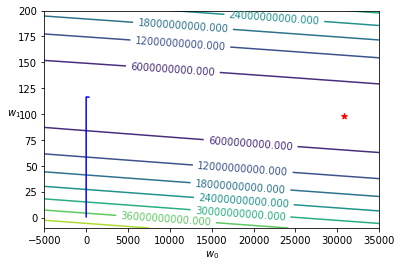

In [31]:
w_history = h._w_history
plot_contour(X_train, y_train, w_history, -5000, 35000, -10, 200, lr.intercept_, lr.coef_[0])

欲使用梯度遞減來進行最適化，通常會搭配兩種技法來增加效率：

1. 特徵矩陣的標準化（Standardization）
2. 進階的梯度遞減演算方法

特徵矩陣的標準化可以使用在機器學習入門章節介紹過的 Scikit-Learn 轉換器：最小最大標準化（Min-max scaler），標準化後得到的 $w^{(scaled)}$ 要再記得實施「逆」轉換。

\begin{align}
\hat{y} &= X^{(scaled)} w^{(scaled)} \\
&= w_0^{(scaled)}x_0 + \sum_i w_i^{(scaled)} x_i^{(scaled)} \\
&= w_0^{(scaled)} + \sum_i w_i^{(scaled)} \frac{x_i - x_i^{(min)}}{x_i^{(max)} - x_i^{(min)}}
\end{align}

\begin{align}
w_0 &= w_0^{(scaled)} - \sum_{i=1} w_i^{(scaled)} \frac{x_i^{(min)}}{x_i^{(max)} - x_i^{(min)}} \\
w_i &= \sum_{i=1} \frac{w_i^{(scaled)}}{x_i^{(max)} - x_i^{(min)}}
\end{align}

將已經過最小最大標準化後的特徵矩陣輸入預測器類別訓練，就能得到的 $w^{(scaled)}$。

In [32]:
mms = MinMaxScaler()
X_scaled = mms.fit_transform(X)
y = train['SalePrice'].values
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.intercept_) # 截距項
print(lr.coef_)      # 係數項

63674.358095820746
[522858.98344032]


In [33]:
h = GradientDescent()
h.fit(X_train, y_train, epochs=100000, learning_rate=0.01)
print(h.intercept_) # 截距項
print(h.coef_)      # 係數項

epoch:      0 - loss: 38574561936.864601
epoch:  10000 - loss: 3197795837.637498
epoch:  20000 - loss: 3142864604.714557
epoch:  30000 - loss: 3141503145.580052
epoch:  40000 - loss: 3141469402.099771
epoch:  50000 - loss: 3141468565.774660
epoch:  60000 - loss: 3141468545.046516
epoch:  70000 - loss: 3141468544.532774
epoch:  80000 - loss: 3141468544.520041
epoch:  90000 - loss: 3141468544.519726
63674.3591206031
[522858.97891743]


接著依照「逆」標準化回推 $w$，發現在最小最大標準化之後，就能順利以自定義的 `GradientDescent` 類別進行梯度遞減。

In [34]:
intercept_rescaled = h.intercept_ - (h.coef_ * mms.data_min_ / mms.data_range_)
coef_rescaled = h.coef_ / mms.data_range_
print(intercept_rescaled) # 截距項
print(coef_rescaled)      # 係數項

[30774.03904554]
[98.50395232]


或者常態標準化（Standard scaler），同樣要記得對 $w^{(scaled)}$ 實施「逆」轉換。

\begin{align}
\hat{y} &= X^{(scaled)} w^{(scaled)} \\
&= w_0^{(scaled)}x_0 + \sum_i w_i^{(scaled)} x_i^{(scaled)} \\
&= w_0^{(scaled)} + \sum_i w_i^{(scaled)} \frac{x_i - \mu_{x_i}}{\sigma_{x_i}}
\end{align}

\begin{align}
w_0 &= w_0^{(scaled)} - \sum_{i=1} w_i^{(scaled)} \frac{\mu_{x_i}}{\sigma_{x_i}} \\
w_i &= \sum_{i=1} \frac{w_i^{(scaled)}}{\sigma_{x_i}}
\end{align}

將已經過常態標準化後的特徵矩陣輸入預測器類別訓練，就能得到的 $w^{(scaled)}$。

In [35]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.intercept_) # 截距項
print(lr.coef_)      # 係數項

180053.20294084703
[51744.16536903]


In [36]:
h = GradientDescent()
h.fit(X_train, y_train, epochs=10000, learning_rate=0.001)
print(h.intercept_) # 截距項
print(h.coef_)      # 係數項

epoch:      0 - loss: 38574730599.218040
epoch:   1000 - loss: 3763987629.644883
epoch:   2000 - loss: 3152443788.694848
epoch:   3000 - loss: 3141662791.806108
epoch:   4000 - loss: 3141471997.043127
epoch:   5000 - loss: 3141468606.167773
epoch:   6000 - loss: 3141468545.625978
epoch:   7000 - loss: 3141468544.539675
epoch:   8000 - loss: 3141468544.520079
epoch:   9000 - loss: 3141468544.519723
180053.2025929845
[51744.16539333]


接著依照「逆」標準化回推 $w$，發現在常態標準化之後，就能順利以自定義的 `GradientDescent` 類別進行梯度遞減。

In [37]:
intercept_rescaled = h.intercept_ - h.coef_ * ss.mean_ / ss.scale_
coef_rescaled = h.coef_ / ss.scale_
print(intercept_rescaled) # 截距項
print(coef_rescaled)      # 係數項

[30774.0373182]
[98.50395322]


另外一種為單純的梯度遞減增加效率的手法是進階的梯度遞減，這些演算方法目前仍處於蓬勃發展的階段，已經廣泛被資料科學家、機器學習工程師應用的有 Momentum、AdaGrad(Adaptive Gradient Descent)、RMSprop(Root mean square propagation)與 Adam(Adaptive moment estimation)。與單純梯度遞減相較，各個進階梯度遞減都試著從學習速率與梯度這兩方面著手調整，其一是引進調適的學習速率（Adaptive methods），如果距離 $J(w)$ 低點遠就用大的學習速率、反之距離近就用小的學習速率；其二是記錄從訓練開始的梯度量值，藉由過去已實現的梯度來判斷和 $J(w)$ 低點的相對位置，如果歷史梯度都很大，表示離低點遠，如果歷史梯度都很小，表示離低點進。就像是一個懂得在不同距離賽事、穿著適當裝備以及使用相應配速的跑者（在中距離場地賽穿著釘鞋與使用九成最大攝氧量配速、在長距離路跑賽穿著厚底鞋與使用七成最大攝氧量配速）。

我們簡單地以 AdaGrad 為例，AdaGrad 將原本單純梯度遞減的式子改寫為：

\begin{equation}
ssg = \sum^{t-1} (\frac{\partial J}{\partial w})^2
\end{equation}

\begin{equation}
w := w -\alpha \frac{1}{\epsilon + \sqrt{ssg}} \frac{\partial J}{\partial w}
\end{equation}

\begin{equation}
where \; \epsilon = 10^{-6}
\end{equation}

AdaGrad 演算方法針對不同 $w_i$ 記錄其歷史梯度的平方和藉此來調適學習速率，因為放在分母的緣故，當歷史梯度的平方和愈大，會調降學習速率；反之當歷史梯度的平方和愈小，會調升學習速率，$\epsilon$ 會設定一個極小值（例如 `tf.keras` 使用 `1e-06`）避免分母為零的情況發生。

自定義一個 `AdaGrad` 類別繼承 `GradientDescent` 類別並改寫其 `fit()` 方法由原本的單純梯度遞減變為 AdaGrad。

In [38]:
class AdaGrad(GradientDescent):
    """
    This class defines the Adaptive Gradient Descent algorithm for linear regression.
    """
    def fit(self, X_train, y_train, epochs=10000, learning_rate=0.01, epsilon=1e-06):
        self._X_train = X_train.copy()
        self._y_train = y_train.copy()
        self._m = self._X_train.shape[0]
        if self._fit_intercept:
            X0 = np.ones((self._m, 1), dtype=float)
            self._X_train = np.concatenate([X0, self._X_train], axis=1)
        n = self._X_train.shape[1]
        self._w = np.random.rand(n)
        # 初始化 ssg
        ssg = np.zeros(n, dtype=float)
        n_prints = 10
        print_iter = epochs // n_prints
        w_history = dict()
        for i in range(epochs):
            current_w = self._w.copy()
            w_history[i] = current_w
            mse = self.mean_squared_error()
            gradient = self.find_gradient()
            ssg += gradient**2
            ada_grad = gradient / (epsilon + ssg**0.5)
            if i % print_iter == 0:
                print("epoch: {:6} - loss: {:.6f}".format(i, mse))
            # 以 adaptive gradient 更新 w
            self._w -= learning_rate*ada_grad
        w_ravel = self._w.copy().ravel()
        self.intercept_ = w_ravel[0]
        self.coef_ = w_ravel[1:]
        self._w_history = w_history

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.intercept_) # 截距項
print(lr.coef_)      # 係數項

30774.037736162078
[98.50395317]


In [40]:
h = AdaGrad()
h.fit(X_train, y_train, epochs=500000, learning_rate=100)
print(h.intercept_) # 截距項
print(h.coef_)      # 係數項

epoch:      0 - loss: 38445917993.077576
epoch:  50000 - loss: 3146435374.819119
epoch: 100000 - loss: 3141887793.680318
epoch: 150000 - loss: 3141504799.902792
epoch: 200000 - loss: 3141471686.153493
epoch: 250000 - loss: 3141468816.799205
epoch: 300000 - loss: 3141468568.118027
epoch: 350000 - loss: 3141468546.564972
epoch: 400000 - loss: 3141468544.696979
epoch: 450000 - loss: 3141468544.535080
30773.92524140127
[98.50401916]


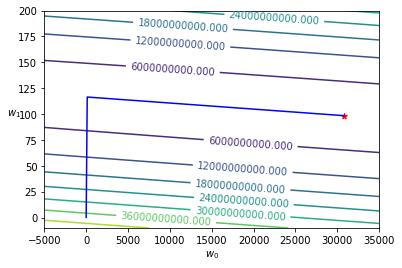

In [41]:
w_history = h._w_history
plot_contour(X_train, y_train, w_history, -5000, 35000, -10, 200, lr.intercept_, lr.coef_[0])

改採用 `AdaGrad` 類別後發現即便沒有進行特徵矩陣的標準化，也能夠順利最適化 $w$。在實際採用梯度遞減進行最適化時，通常會將標準化與進階演算手法兩者搭配運作，這也是為什麼在 [Kaggle](https://www.kaggle.com/) 網站上看到很多採用高階機器學習框架的專案範例，都會對特徵矩陣做標準化並指定參數 `optimizer` 為 `RMSprop`、`Adam` 或 `Adagrad` 的緣由。 

## 延伸閱讀

1. Machine Learning Basics. In: Ian Goodfellow ,Yoshua Bengio, and Aaron Courville, Deep Learning (https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/)
2. Sebastian Ruder: An overview of gradient descent optimization algorithms (https://ruder.io/optimizing-gradient-descent/index.html)
3. Training Models. In: Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/)
4. Normal Equation (http://mlwiki.org/index.php/Normal_Equation)
5. Computational complexity (https://en.wikipedia.org/wiki/Computational_complexity)
6. Gradient descent (https://en.wikipedia.org/wiki/Gradient_descent)